In [61]:
import tensorflow as tf

# Verificar si TensorFlow detecta la GPU
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

if physical_devices:
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("GPU(s) detected and configured.")
else:
    print("No GPU detected.")


Num GPUs Available:  0
No GPU detected.


**Preprocesamiento**

In [62]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


In [63]:
# Función para cargar una imagen y su máscara
def load_image_and_mask(image_path, mask_path):
    image = Image.open(image_path).convert('RGB')
    mask = Image.open(mask_path)
    return np.array(image), np.array(mask)

In [64]:
def resize_image(image, size=(256, 256)):
    return np.array(Image.fromarray(image).resize(size))


In [65]:
def preprocess_image(image):
    # Redimensionar la imagen
    resized_image = resize_image(image)
    # Normalizar los píxeles de la imagen
    normalized_image = resized_image.astype('float32') / 255.0
    return normalized_image


def preprocess_mask(mask, num_classes):
    # Redimensionar la máscara
    resized_mask = resize_image(mask)
    # Convertir la máscara a categorías (one-hot encoding)
    mask_cat = to_categorical(resized_mask, num_classes=num_classes)
    return mask_cat


In [66]:
# Directorio que contiene las imágenes y las máscaras
images_dir = '../RGB/images/'
masks_dir = '../RGB/masks/'

# Preprocesamiento de las imágenes
preprocessed_images = []
preprocessed_masks = []

# Recorrer todas las imágenes y máscaras
for image_file in os.listdir(images_dir):
    if image_file.endswith('.tif'):
        image_path = os.path.join(images_dir, image_file)
        mask_file = image_file.replace('.tif', '.tif')
        mask_path = os.path.join(masks_dir, mask_file)
        
        # Cargar la imagen y la máscara
        image, mask = load_image_and_mask(image_path, mask_path)
        
        # Preprocesar la imagen y la máscara
        preprocessed_image = preprocess_image(image)
        preprocessed_mask = preprocess_mask(mask, num_classes=5)
                
        # Agregar la imagen y la máscara preprocesadas
        preprocessed_images.append(preprocessed_image)
        preprocessed_masks.append(preprocessed_mask)

KeyboardInterrupt: 

In [ ]:
print('Número de imágenes:', len(preprocessed_images))
print('Número de máscaras:', len(preprocessed_masks))

print('Tamaño de las imágenes:', preprocessed_images[0].shape)
print('Tamaño de las máscaras:', preprocessed_masks[0].shape)

Número de imágenes: 41
Número de máscaras: 41
Tamaño de las imágenes: (256, 256, 3)
Tamaño de las máscaras: (256, 256, 5)


In [ ]:
from sklearn.model_selection import train_test_split

# Convertir las listas a arrays numpy
preprocessed_images = np.array(preprocessed_images)
preprocessed_masks = np.array(preprocessed_masks)

# Dividir los datos en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(preprocessed_images, preprocessed_masks, test_size=0.2, random_state=42)

# Imprimir información sobre los conjuntos
print('Número de imágenes de entrenamiento:', len(X_train))
print('Número de imágenes de validación:', len(X_val))
print('Tamaño de las imágenes:', X_train[0].shape)
print('Tamaño de las máscaras:', y_train[0].shape)

Número de imágenes de entrenamiento: 32
Número de imágenes de validación: 9
Tamaño de las imágenes: (256, 256, 3)
Tamaño de las máscaras: (256, 256, 5)


**Modelo**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate

def unet_model(input_shape=(256, 256, 3), num_classes=5):
    inputs = Input(input_shape)
    
    # Codificación (downsampling)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Capa central
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decodificación (upsampling)
    up6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up6, conv4], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv3], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up8, conv2], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    up9 = concatenate([up9, conv1], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    # Capa de salida
    outputs = Conv2D(num_classes, 1, activation='softmax')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Construir el modelo
model = unet_model(input_shape=(256, 256, 3), num_classes=num_classes)

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Entrenamiento del modelo
history = model.fit(X_train, y_train, batch_size=8, epochs=10, validation_data=(X_val, y_val))


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 31s 7s/step - accuracy: 0.4143 - loss: 1.4521 - val_accuracy: 0.5120 - val_loss: 1.1456
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step - accuracy: 0.4596 - loss: 1.2041 - val_accuracy: 0.5120 - val_loss: 1.1312
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step - accuracy: 0.5213 - loss: 1.1177 - val_accuracy: 0.5120 - val_loss: 1.1273
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step - accuracy: 0.4943 - loss: 1.1223 - val_accuracy: 0.5123 - val_loss: 1.1455
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step - accuracy: 0.5067 - loss: 1.0972 - val_accuracy: 0.5120 - val_loss: 1.1307
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step - accuracy: 0.4998 - loss: 1.0953 - val_accuracy: 0.5122 - val_loss: 1.1269
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step - accuracy: 0.5359 - loss: 1.0351 - val_accuracy: 0.5121 - val_loss: 1.1295
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step - accuracy: 0.5159 - loss: 1.0753 - val_accuracy: 0.5120 - val_loss: 1.1451
Epoch 9/

In [ ]:
# Evaluar el modelo en el conjunto de validación
evaluation = model.evaluate(X_val, y_val)

# Obtener las métricas de evaluación
loss = evaluation[0]
accuracy = evaluation[1]

# Imprimir las métricas de evaluación
print("Loss:", loss)
print("Accuracy:", accuracy)

# Obtener las predicciones del modelo en el conjunto de validación
y_pred = model.predict(X_val)

# Redondear las predicciones a valores binarios
y_pred_classes = np.argmax(y_pred, axis=-1)
y_val_classes = np.argmax(y_val, axis=-1)

# Calcular F1-Score
from sklearn.metrics import f1_score
f1 = f1_score(y_val_classes.flatten(), y_pred_classes.flatten(), average='weighted')

# Calcular IoU
from sklearn.metrics import jaccard_score
iou = jaccard_score(y_val_classes.flatten(), y_pred_classes.flatten(), average='weighted')

# Imprimir métricas adicionales
print("F1-Score:", f1)
print("IoU:", iou)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5539 - loss: 1.1176
Loss: 1.1175669431686401
Accuracy: 0.5538872480392456
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
F1-Score: 0.4393157978802399
IoU: 0.32146510863775557


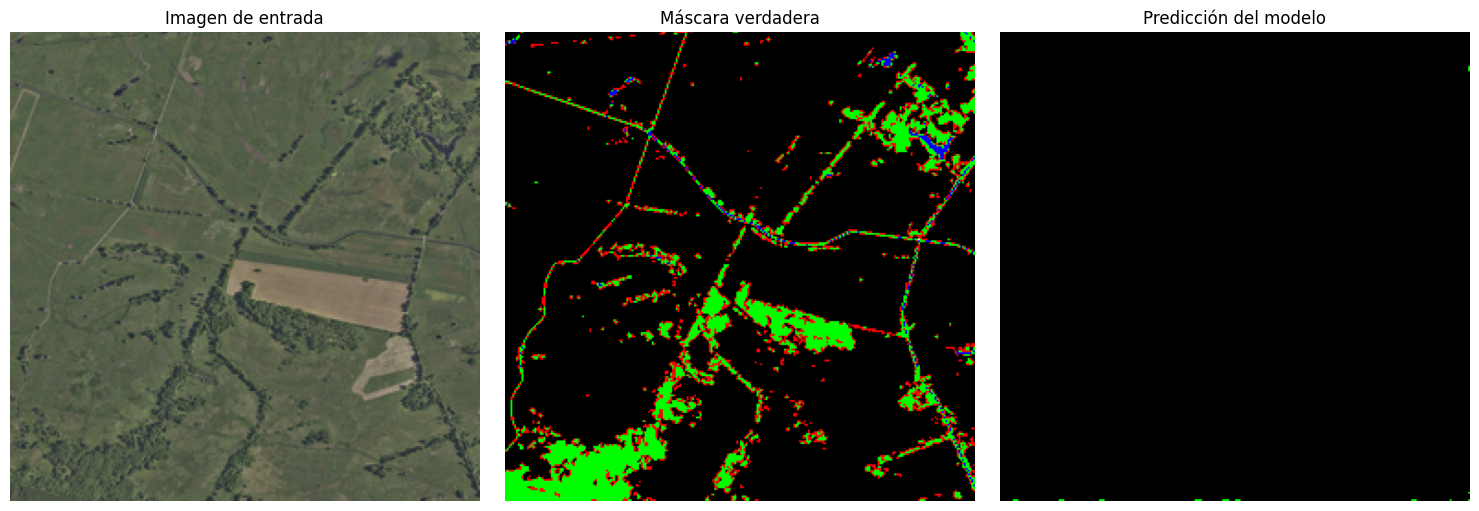

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Definir colores para las clases
colors = [[0, 0, 0],    # Negro, probablemente áreas con poca vegetación o sin
          [255, 0, 0],  # Rojo, probablemente para edificaciones
          [0, 255, 0],  # Verde, probablemente para vegetación
          [0, 0, 255],  # Azul, probablemente agua
          [255, 255, 255]]  # Blanco, probablemente caminos

# Función para convertir la máscara a una imagen colorida
def mask_to_colored_image(mask, colors):
    height, width = mask.shape
    colored_image = np.zeros((height, width, 3), dtype=np.uint8)
    for class_id, color in enumerate(colors):
        colored_image[mask == class_id] = color
    return colored_image

# Función para visualizar las imágenes, máscaras y predicciones
def display_results(X_val, y_val, y_pred, num_images=5):
    plt.figure(figsize=(15, num_images * 5))
    
    for i in range(num_images):
        # Imagen de entrada
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.title('Imagen de entrada')
        plt.imshow(X_val[i])
        plt.axis('off')
        
        # Máscara verdadera
        plt.subplot(num_images, 3, i * 3 + 2)
        plt.title('Máscara verdadera')
        y_val_colored = mask_to_colored_image(np.argmax(y_val[i], axis=-1), colors)
        plt.imshow(y_val_colored)
        plt.axis('off')
        
        # Predicción del modelo
        plt.subplot(num_images, 3, i * 3 + 3)
        plt.title('Predicción del modelo')
        y_pred_colored = mask_to_colored_image(y_pred[i], colors)
        plt.imshow(y_pred_colored)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualizar los resultados
display_results(X_val, y_val, y_pred_classes, num_images=5)
